# Importing Libraries

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
# Create Known Parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
print(f"{X[:10]}, \n {y[:10]}")

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]]), 
 tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280],
        [0.3350],
        [0.3420],
        [0.3490],
        [0.3560],
        [0.3630]])


In [3]:
print(f"length of X: {len(X)} \nlength of y: {len(y)}")

length of X: 100 
length of y: 100


# Splitting Data into Train & Test Set

In [4]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

# Function to Plot Data

In [5]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    """
    plot training data , test data & compares to prediction
    """
    plt.figure(figsize=(10, 5))

    # Plot Training data Color = Blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

    # Plot Test data Color = Green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test Data")

    # Plot Prediction data if exists Color = Red
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14})

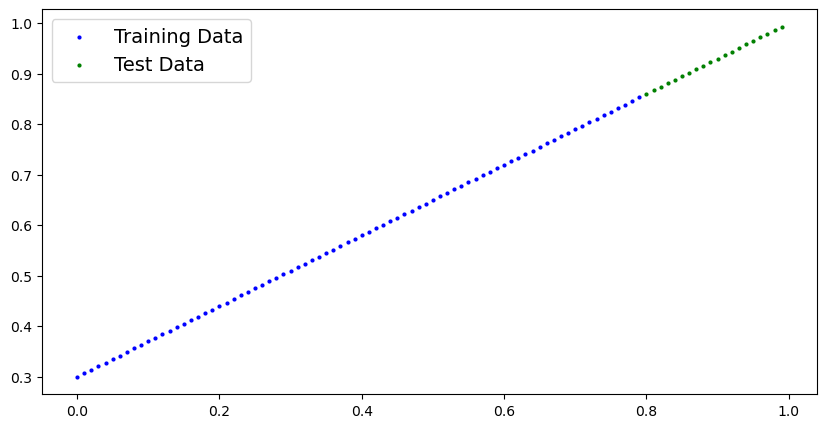

In [6]:
plot_predictions()

# Create Linear Regression Model Class

In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float)
        )
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(
        self, x: torch.tensor
    ) -> (
        torch.tensor
    ):  # It just tells humans and tools what the function should return.Removing it does not break anything
        return self.weights * x + self.bias

# Checking Content of our Pytorch Model

In [8]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()
# Checkout parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List of named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

# Making Predictions

In [10]:
with torch.inference_mode():  # Maks prediction faster as it doesn't keep track of data such as gradient
    y_pred = model_0(X_test)
y_pred

tensor([[0.3982],
        [0.4015],
        [0.4049],
        [0.4083],
        [0.4116],
        [0.4150],
        [0.4184],
        [0.4217],
        [0.4251],
        [0.4285],
        [0.4318],
        [0.4352],
        [0.4386],
        [0.4419],
        [0.4453],
        [0.4487],
        [0.4520],
        [0.4554],
        [0.4588],
        [0.4621]])

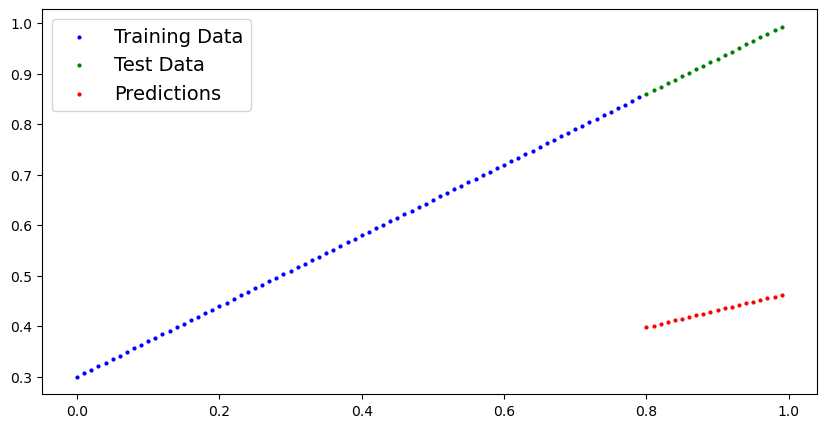

In [11]:
plot_predictions(predictions=y_pred)

# Setup Loss function & Optimizer

In [12]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### PyTorch training loop
For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |


In [13]:
# Set a manual seed to ensure reproducibility of results (weights, randomness, etc.)
torch.manual_seed(42)

# Set the number of epochs (iterations over the entire training dataset)
epochs = 200

# Lists to keep track of metrics during training
epoch_count = []  # Stores epoch numbers for which we log progress
loss_values = []  # Stores training loss values
test_loss_values = []  # Stores test (validation) loss values

# Start the training loop
for epoch in range(epochs):

    # Set the model to training mode (enables dropout, batchnorm, etc. if present)
    model_0.train()

    # Perform a forward pass on the training data
    y_pred = model_0(X_train)

    # Calculate the loss between predictions and actual training labels
    loss = loss_fn(y_pred, y_train)

    # Reset gradients to zero before backpropagation to prevent accumulation
    optimizer.zero_grad()

    # Backward pass - compute gradients of the loss w.r.t model parameters
    loss.backward()

    # Perform a single optimization step (update model parameters)
    optimizer.step()

    # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
    model_0.eval()
    with torch.inference_mode():  # Context manager to turn off gradient calculation for inference
        # Perform a forward pass on the test data
        test_pred = model_0(X_test)

        # Calculate the loss on the test data
        test_loss = loss_fn(test_pred, y_test)

    # Every 10 epochs, record and print the metrics for analysis
    if epoch % 10 == 0:
        epoch_count.append(epoch)  # Record current epoch
        loss_values.append(loss)  # Record training loss
        test_loss_values.append(test_loss)  # Record test loss

        # Print training and test loss to monitor progress
        print(f"Epoch: {epoch} | Loss: {loss} | Test_loss: {test_loss}")

        # Print current model parameters (weights and biases)
        print(model_0.state_dict())

    # Debug print for weights and biases (optional, commented out)
    # print(f"Weight: {weight} \nBias: {bias}")

Epoch: 0 | Loss: 0.31469792127609253 | Test_loss: 0.48281747102737427
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.19909533858299255 | Test_loss: 0.3474648892879486
OrderedDict([('weights', tensor([0.3801])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08958515524864197 | Test_loss: 0.21752354502677917
OrderedDict([('weights', tensor([0.4195])), ('bias', tensor([0.3336]))])
Epoch: 30 | Loss: 0.05288771912455559 | Test_loss: 0.1439102590084076
OrderedDict([('weights', tensor([0.4525])), ('bias', tensor([0.3776]))])
Epoch: 40 | Loss: 0.045192889869213104 | Test_loss: 0.11271438747644424
OrderedDict([('weights', tensor([0.4762])), ('bias', tensor([0.3876]))])
Epoch: 50 | Loss: 0.04140976816415787 | Test_loss: 0.09821617603302002
OrderedDict([('weights', tensor([0.4952])), ('bias', tensor([0.3851]))])
Epoch: 60 | Loss: 0.03795855492353439 | Test_loss: 0.0888485461473465
OrderedDict([('weights', tensor([0.5127])), ('bias', tensor([0.3788]

In [14]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

In [15]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6944])), ('bias', tensor([0.2968]))])

In [16]:
weight, bias

(0.7, 0.3)

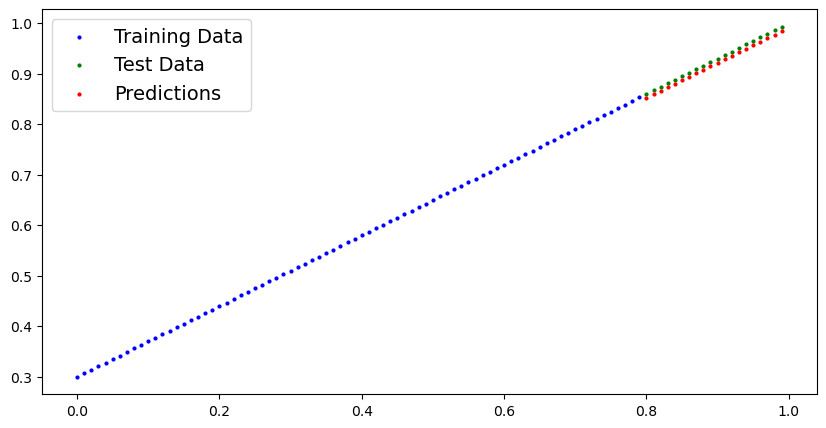

In [17]:
plot_predictions(predictions=y_preds_new)

# Plotting

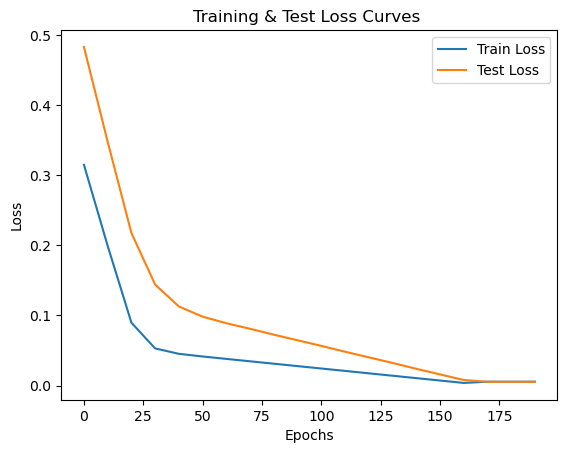

In [18]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training & Test Loss Curves ")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

# Saving Model

In [19]:
# Create Model Directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create Model save Path
MODEL_NAME = "V1_workflow_workshop.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save Model state dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)
print(f"Model is Saved to {MODEL_SAVE_PATH}")

Model is Saved to models/V1_workflow_workshop.pt


# Loading Model

In [20]:
# To load a saved model using its state_dict, we must first re-create the model architecture.
# This creates a new instance of the same model class we originally trained and saved.
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict (i.e., the trained weights and biases) into the new model instance.
# This updates the new model with the parameters learned during training, effectively restoring its state.

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>